In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer
import spacy
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


In [2]:
!ls /home/aaron/PythonProjects/234spring19/finalProjectData/
#contents of yelp dataset include 6 json files and 2 pdfs
#NOTE: additional files are to be made and added to this directory later

business.json				 tip.json
checkin.json				 Untitled.ipynb
Dataset_Challenge_Dataset_Agreement.pdf  user.json
photo.json				 Yelp_Dataset_Challenge_Round_13.pdf
review.json


In [3]:
!head -n1 /home/aaron/PythonProjects/234spring19/finalProjectData/business.json | jq .

{
  "business_id": "1SWheh84yJXfytovILXOAQ",
  "name": "Arizona Biltmore Golf Club",
  "address": "2818 E Camino Acequia Drive",
  "city": "Phoenix",
  "state": "AZ",
  "postal_code": "85016",
  "latitude": 33.5221425,
  "longitude": -112.0184807,
  "stars": 3,
  "review_count": 5,
  "is_open": 0,
  "attributes": {
    "GoodForKids": "False"
  },
  "categories": "Golf, Active Life",
  "hours": null
}


In [4]:
!wc -l /home/aaron/PythonProjects/234spring19/finalProjectData/business.json #number of business in data

192609 /home/aaron/PythonProjects/234spring19/finalProjectData/business.json


In [5]:
#jq -c to output by line
#select businesses with over 500 reviews
! jq -c 'select(.review_count>500)' /home/aaron/PythonProjects/234spring19/finalProjectData/business.json > /home/aaron/PythonProjects/234spring19/finalProjectData/subset_business_over500.json

In [7]:
!wc -l /home/aaron/PythonProjects/234spring19/finalProjectData/subset_business_over500.json #number of businesses with more than 250 reviews

1263 /home/aaron/PythonProjects/234spring19/finalProjectData/subset_business_over500.json


In [8]:
! jq -c 'select(.review_count<=500) and .review_count>250' /home/aaron/PythonProjects/234spring19/finalProjectData/business.json | wc -l

191346


# There are too many businesses that have between 250 and 500 reviews, therefore it should be noted our analysis will consist of businesses with over 500 reviews
## This is important because analysis of reviews for less "popular" businesses may be different from more popular businesses

In [3]:
business = pd.read_json('/home/aaron/PythonProjects/234spring19/finalProjectData/subset_business_over500.json', lines = True)
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"1770 W Horizon Ridge, Ste 100","{'DriveThru': 'False', 'RestaurantsAttire': ''...",jScBTQtdAt-8RshaiBEHgw,"Ethnic Food, American (New), Burgers, Food, Re...",Henderson,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '...",1,36.010745,-115.064803,Served,89012,664,4.5,NV
1,550 N Hayden Rd,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",nsNONDHbV7Vudqh21uicqw,"Seafood, Restaurants",Scottsdale,"{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",1,33.454286,-111.909405,Salt Cellar,85257,526,3.5,AZ
2,3655 Las Vegas Blvd S,"{'RestaurantsTakeOut': 'True', 'RestaurantsDel...",6fPQJq4f_yiq1NHn0fd11Q,"French, Restaurants, Creperies",Las Vegas,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,36.112527,-115.171351,La Creperie,89109,535,3.5,NV
3,1008 E Camelback Rd,"{'Alcohol': 'u'full_bar'', 'RestaurantsAttire'...",dUffgo9Lh_Vk9TLuFR5ywg,"Restaurants, Pizza, Sandwiches, Italian",Phoenix,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,33.509510,-112.060238,Oregano's Pizza Bistro,85014,563,3.5,AZ
4,3131 Las Vegas Blvd S,"{'BusinessParking': '{'garage': True, 'street'...",_pBXtjN43eqMV0XZTz7nmw,"Music Venues, Dance Clubs, Arts & Entertainmen...",Las Vegas,"{'Wednesday': '22:30-4:0', 'Friday': '22:30-4:...",0,36.129243,-115.165644,Encore Beach Club at Night,89109,865,3.5,NV


In [10]:
business.tail()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
1258,"9915 W McDowell Rd, Ste 104","{'RestaurantsGoodForGroups': 'True', 'Restaura...",KOEBBp2PhiV_4PkW9eo9Sg,"Greek, Restaurants, Middle Eastern, Mediterran...",Avondale,"{'Monday': '0:0-0:0', 'Tuesday': '10:30-18:0',...",1,33.464143,-112.273057,Pita Kitchen - Avondale,85392,569,4.5,AZ
1259,7070 N Durango Dr,"{'NoiseLevel': 'u'average'', 'OutdoorSeating':...",qRymrsLmlA34bC8PvNoujg,"Mediterranean, Caterers, Event Planning & Serv...",Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,36.289201,-115.287334,Market Grille Cafe,89149,572,4.0,NV
1260,3240 S Arville St,"{'BusinessParking': '{'garage': False, 'street...",P8uECqGqXWTwEndkh-6bQw,"Sandwiches, Pizza, Chicken Wings, Italian, Res...",Las Vegas,"{'Monday': '12:0-21:0', 'Tuesday': '12:0-21:0'...",1,36.130804,-115.198971,Naked City Pizza Shop,89102,576,4.0,NV
1261,"8975 S Eastern Ave, Ste 3C","{'Alcohol': 'u'none'', 'BusinessParking': '{'g...",p5rpYtxS5xPQjt3MXYVEwA,"Sandwiches, Cafes, Pizza, Vegetarian, Gluten-F...",Las Vegas,"{'Monday': '9:30-19:30', 'Tuesday': '7:0-22:0'...",1,36.026212,-115.119341,Greens and Proteins,89123,704,4.0,NV
1262,5611 S Valley View Blvd,"{'Caters': 'True', 'RestaurantsTableService': ...",ngs16C2M_uTq2zXamltHVw,"Farmers Market, Caterers, Food, Street Vendors...",Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '11:30-20:30'...",1,36.087895,-115.190329,Jessie Rae's BBQ,89118,595,4.5,NV


In [11]:
business['review_count'].sum()

1234870

In [15]:
biz_id = business['business_id'].values

In [13]:
len(biz_id)

1263

# There are over 1 million reviews for these businesses, once again due to computer limitations we will take a subset of the data
## We will randomly select 50 reviews for each business

In [14]:
!head -n1 /home/aaron/PythonProjects/234spring19/finalProjectData/review.json | jq .

{
  "review_id": "Q1sbwvVQXV2734tPgoKj4Q",
  "user_id": "hG7b0MtEbXx5QzbzE6C_VA",
  "business_id": "ujmEBvifdJM6h6RLv4wQIg",
  "stars": 1,
  "useful": 6,
  "funny": 1,
  "cool": 0,
  "text": "Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.",
  "date": "2013-05-07 04:34:36"
}


In [16]:
!touch /home/aaron/PythonProjects/234spring19/finalProjectData/subset_review.json #create empty file in case notebook needs to run again
for b in biz_id:
    !grep -- $b /home/aaron/PythonProjects/234spring19/finalProjectData/review.json | shuf -n 50 >> /home/aaron/PythonProjects/234spring19/finalProjectData/subset_review.json
    #grep mathces unique business_id to reviews then randomly selects 50 reviews and appends to file
    #jq -c might have worked as well but just in case grep was used for input for shuf
    #shuf randomly selects 50 reviews that matched the business_id
    #since >> appends to file it is important to use the first line in this cell to create a new empty file or you will add on to existing lines if you run this cell multiple times

In [17]:
!wc -l /home/aaron/PythonProjects/234spring19/finalProjectData/subset_review.json 
#double check it worked 
#expect output sample number times number of businesses, e.g. if 1263 businesses and random sample 50 reviews then expect 63150 lines

63150 /home/aaron/PythonProjects/234spring19/finalProjectData/subset_review.json


In [4]:
reviews = pd.read_json('/home/aaron/PythonProjects/234spring19/finalProjectData/subset_review.json', lines = True)

In [19]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,jScBTQtdAt-8RshaiBEHgw,0,2016-06-21 20:54:28,0,1jKn3mgSamCvmAPYRwRsew,3,First time here and i would like to say the pl...,1,WXA_4WVO1tpD0So3pZOQQQ
1,jScBTQtdAt-8RshaiBEHgw,3,2016-07-02 18:37:12,1,rtGw_i8FcpwIRNS1OWmuHA,5,I hope that this place makes it because everyt...,3,bgn06l4XfW9P_-TgLPS3tw
2,jScBTQtdAt-8RshaiBEHgw,1,2018-01-11 02:42:38,0,S0R9z62w4Rzc741reFNBmg,4,I had the miso pork belly burger and the thing...,1,hJnqE_-Ijr55MFkbc1YghQ
3,jScBTQtdAt-8RshaiBEHgw,2,2017-10-20 01:14:01,0,Ot5kLJ3TDk0YXZ1FBaoESg,5,Delicious food with very friendly and accommod...,3,fMSmWCg5ge5pxVlbCgjtxQ
4,jScBTQtdAt-8RshaiBEHgw,1,2018-03-07 22:42:02,1,-FVXDl7uUeIiHuk5Jql8aQ,5,This place is definitely worth the search. Loc...,1,Gn_06I6jbXgKtc64SEuIVw


In [20]:
reviews.tail()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
63145,ngs16C2M_uTq2zXamltHVw,0,2016-05-27 16:33:00,0,USWSsUDtvT8GwRKMXoHr5A,5,Hole in the wall smokey bbq. Came here for lun...,1,V26EHxCEXhJ0Ziv3GR-Vkg
63146,ngs16C2M_uTq2zXamltHVw,0,2017-12-28 15:28:30,0,8cw87kKbFh2hPTzWpM-ULw,5,"OMG!! The absolute BEST barbeque in Vegas, he...",0,njkK2DuI-Zy2yq_Vs6O93A
63147,ngs16C2M_uTq2zXamltHVw,0,2017-12-29 20:59:09,0,_1rL2pFzuxrqJBkR9lj5Ow,5,A lot of people will not like this place becau...,0,J18ol0RI1TuyqGKFZJfh3w
63148,ngs16C2M_uTq2zXamltHVw,0,2018-02-19 22:10:33,0,72mCdUwWxvp2qhVQukbYfg,5,Awesome spot. The maniac fries are unreal. Add...,0,sONa3N__KYh74Ylyqz5FpQ
63149,ngs16C2M_uTq2zXamltHVw,0,2017-04-17 20:47:50,0,5z84GTLA0X-n3-i2gdyhmg,1,Just stopped by this place and had the ribs an...,1,IjY4cxh6epnx-Q4aIaHSfQ


In [21]:
reviews['user_id'].nunique() #number of unique users in subset reviews (53789)

53753

## Subset of user data took too long to acquire, will include in future analysis
## Interesting to see what user attributes may influence reviews and creating networks from the friends list may also be an interesting analysis

In [22]:
!head -n1 /home/aaron/PythonProjects/234spring19/finalProjectData/user.json | jq .

{
  "user_id": "l6BmjZMeQD3rDxWUbiAiow",
  "name": "Rashmi",
  "review_count": 95,
  "yelping_since": "2013-10-08 23:11:33",
  "useful": 84,
  "funny": 17,
  "cool": 25,
  "elite": "2015,2016,2017",
  "friends": "c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g, ajcnq75Z5xxkvUSmmJ1bCg, BSMAmp2-wMzCkhTfq9ToNg, jka10dk9ygX76hJG0gfPZQ, dut0e4xvme7QSlesOycHQA, l4l5lBnK356zBua7B-UJ6Q, 0HicMOOs-M_gl2eO-zES4Q, _uI57wL2fLyftrcSFpfSGQ, T4_Qd0YWbC3co6WSMw4vxg, iBRoLWPtWmsI1kdbE9ORSA, xjrUcid6Ymq0DoTJELkYyw, GqadWVzJ6At-vgLzK_SKgA, DvB13VJBmSnbFXBVBsKmDA, vRP9nQkYTeNioDjtxZlVhg, gT0A1iN3eeQ8EMAjJhwQtw, 6yCWjFPtp_AD4x93WAwmnw, 1dKzpNnib-JlViKv8_Gt5g, 3Bv4_JxHXq-gVLOxYMQX0Q, ikQyfu1iViYh8T0us7wiFQ, f1GGltNaB7K5DR1jf3dOmg, tgeFUChlh7v8bZFVl2-hjQ, -9-9oyXlqsMG2he5xIWdLQ, Adj9fBPVJad8vSs-mIP7gw, Ce49RY8CKXVsTifxRYFTsw, M1_7TLi8CbdA89nFLlH4iw, wFsNv-hqbW_F5-IRqfBN6g, 0Q1L7zXHocaUZ2gsG2XJeg, cBFgmOCBdhYa0xoFEAzp_g, VrD_AgiFvzqtlR15vir3SQ, cpE-7HK514Sr5vpSen9CEQ, F1UYelhPFB-zIKlt0ygIZg, CQAL1hvsLMCzuJf9Agl

In [46]:
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"1770 W Horizon Ridge, Ste 100","{'DriveThru': 'False', 'RestaurantsAttire': ''...",jScBTQtdAt-8RshaiBEHgw,"Ethnic Food, American (New), Burgers, Food, Re...",Henderson,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '...",1,36.010745,-115.064803,Served,89012,664,4.5,NV
1,550 N Hayden Rd,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",nsNONDHbV7Vudqh21uicqw,"Seafood, Restaurants",Scottsdale,"{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",1,33.454286,-111.909405,Salt Cellar,85257,526,3.5,AZ
2,3655 Las Vegas Blvd S,"{'RestaurantsTakeOut': 'True', 'RestaurantsDel...",6fPQJq4f_yiq1NHn0fd11Q,"French, Restaurants, Creperies",Las Vegas,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,36.112527,-115.171351,La Creperie,89109,535,3.5,NV
3,1008 E Camelback Rd,"{'Alcohol': 'u'full_bar'', 'RestaurantsAttire'...",dUffgo9Lh_Vk9TLuFR5ywg,"Restaurants, Pizza, Sandwiches, Italian",Phoenix,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,33.509510,-112.060238,Oregano's Pizza Bistro,85014,563,3.5,AZ
4,3131 Las Vegas Blvd S,"{'BusinessParking': '{'garage': True, 'street'...",_pBXtjN43eqMV0XZTz7nmw,"Music Venues, Dance Clubs, Arts & Entertainmen...",Las Vegas,"{'Wednesday': '22:30-4:0', 'Friday': '22:30-4:...",0,36.129243,-115.165644,Encore Beach Club at Night,89109,865,3.5,NV


In [48]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,jScBTQtdAt-8RshaiBEHgw,0,2016-06-21 20:54:28,0,1jKn3mgSamCvmAPYRwRsew,3,First time here and i would like to say the pl...,1,WXA_4WVO1tpD0So3pZOQQQ
1,jScBTQtdAt-8RshaiBEHgw,3,2016-07-02 18:37:12,1,rtGw_i8FcpwIRNS1OWmuHA,5,I hope that this place makes it because everyt...,3,bgn06l4XfW9P_-TgLPS3tw
2,jScBTQtdAt-8RshaiBEHgw,1,2018-01-11 02:42:38,0,S0R9z62w4Rzc741reFNBmg,4,I had the miso pork belly burger and the thing...,1,hJnqE_-Ijr55MFkbc1YghQ
3,jScBTQtdAt-8RshaiBEHgw,2,2017-10-20 01:14:01,0,Ot5kLJ3TDk0YXZ1FBaoESg,5,Delicious food with very friendly and accommod...,3,fMSmWCg5ge5pxVlbCgjtxQ
4,jScBTQtdAt-8RshaiBEHgw,1,2018-03-07 22:42:02,1,-FVXDl7uUeIiHuk5Jql8aQ,5,This place is definitely worth the search. Loc...,1,Gn_06I6jbXgKtc64SEuIVw


# Exploratory Analysis

Reviews are rated stars in the set {1,2,3,4,5} and businesses can be rated those integers or the midpoints e.g. 3.5

In [55]:
np.sort(business['stars'].unique())

array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [56]:
np.sort(reviews['stars'].unique())

array([1, 2, 3, 4, 5])

Since our dataset consists of businesses and reviews from businesses which have over 500 reviews, we can deduce that these businesses are fairly "popular" and would suggest that they should have good ratings. In the plot below we can see that most businesses, nearly half of our dataset, are rated 4.0 stars.

In the plot containing number of reviews for each rating, we see that most reviews are either 4.0 or 5.0 stars. Once again, this agrees with our assumption that number of reviews and ratings have a cooperative effect, meaning a more popular business probably has better reviews and a business with good reviews is probably more popular. We shall investigate this further in the plots below. It should be noted, as in the beginning of this notebook, that our business dataset is the entire **population** of businesses with over 500 reviews from the original dataset but we **randomly sampled** 50 reviews for each business from the original review dataset.

Text(0.5,1,'Number of Businesses for Each Rating')

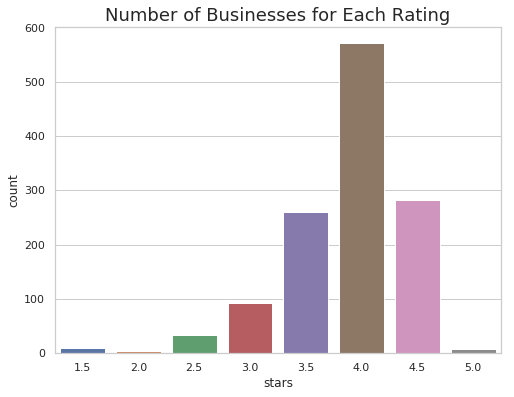

In [120]:
fig = plt.figure(figsize=(8,6))
sns.set(style = 'whitegrid')
sns.countplot(business['stars']).set_title('Number of Businesses for Each Rating',fontsize = 18)

Text(0.5,1,'Number of Reviews for Each Rating')

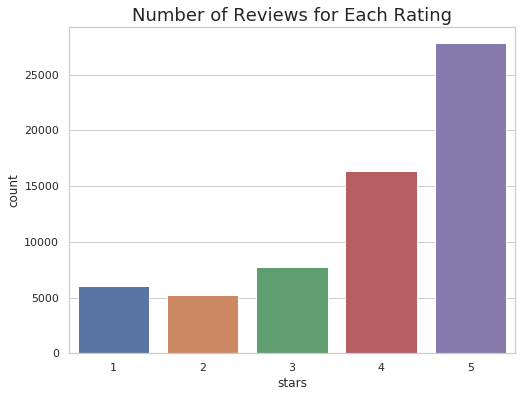

In [119]:
fig = plt.figure(figsize=(8,6))
sns.countplot(reviews['stars']).set_title('Number of Reviews for Each Rating',fontsize = 18)

In the plots below we examine the distribution of the amount of reviews for each business in the dataset. We see that roughly half of the businesses in our dataset have between 585 and 1051 reviews. However, about 150 businesses in the dataset could be considered outliers past the third quartile using the traditional method of Q3 + IQR. In our case Q3 + IQR = 1518 reviews so outliers in this dataset are businesses with over 1518 reviews.

Text(0.5,1,'Distribution of Review Counts for Businesses')

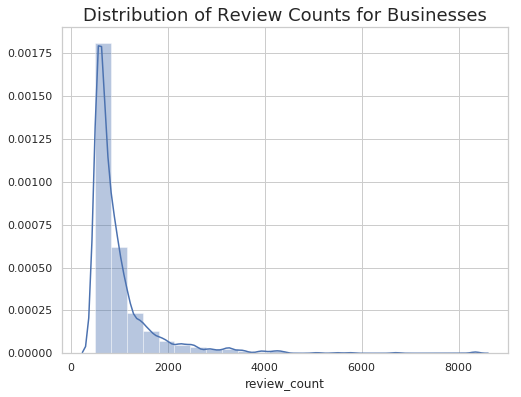

In [118]:
fig = plt.figure(figsize=(8,6))
sns.distplot(business['review_count'], bins = 24).set_title('Distribution of Review Counts for Businesses',fontsize = 18)

Text(0.5,1,'Distribution of Review Counts for Businesses')

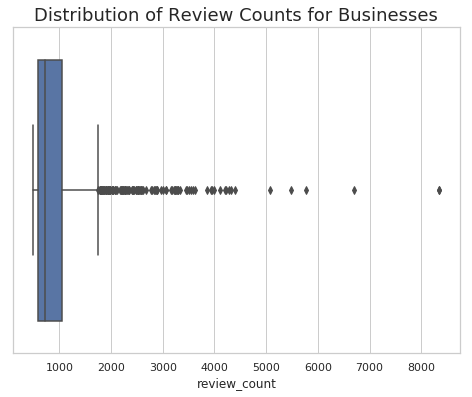

In [117]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(business['review_count']).set_title('Distribution of Review Counts for Businesses',fontsize = 18)

In [63]:
business['review_count'].describe()

count    1263.000000
mean      977.727633
std       726.569427
min       501.000000
25%       585.000000
50%       726.000000
75%      1051.500000
max      8348.000000
Name: review_count, dtype: float64

In [109]:
IQR = 1051.5 - 585
1051.5 + IQR

1518.0

In [110]:
len(business[business['review_count'] > 1518])

150

In the figures below we see the distribtution of review counts for businesses at each rating level. In the first plot we used a traditional boxplot and the second is a boxenplot to show the many quantiles. Surprisingly, we can see that while there are fewer businesses with 2.5 stars, these businesses actually have a lot of reviews (almost the top 40% has over 1000 reviews) suggesting they are popular. There could be many reasons for this, one possible explanation is that these businesses are famous for other reasons than the quality of their service such as a celebrity owner/endorser or being in a landmark location.

Furthermore, we can see that businesses with 5.0, 2.0, and 1.5 star ratings are the least varied and most of these businesses have less than 1000 reviews. There are several explanations for this. One explanation is that there are very few businesses with low ratings and over 500 reviews because most consumers would not continue to go to businesses with low ratings and poor reviews. On the other hand, for the businesses with 5.0 stars, it could be the fact that since these businesses are not as popular it could be easier to achieve such a rating with quality service. An interesting analysis would be to check how long a business can sustain or "survive" at 5 stars until it drops down to a more modest 4.0 or 4.5 stars. Since review dates are available this could be in a future analysis.

Lastly, since the most popular ratings are 4.0, 4.5, and 3.5 respectively, we see that the distribution of review counts for these businesses are the most varied. This is again not very surprising since most businesses in our dataset have these ratings and these ratings are fairly "modest".

Text(0.5,1,'Distribtution of Number of Reviews for Businesses at Each Rating')

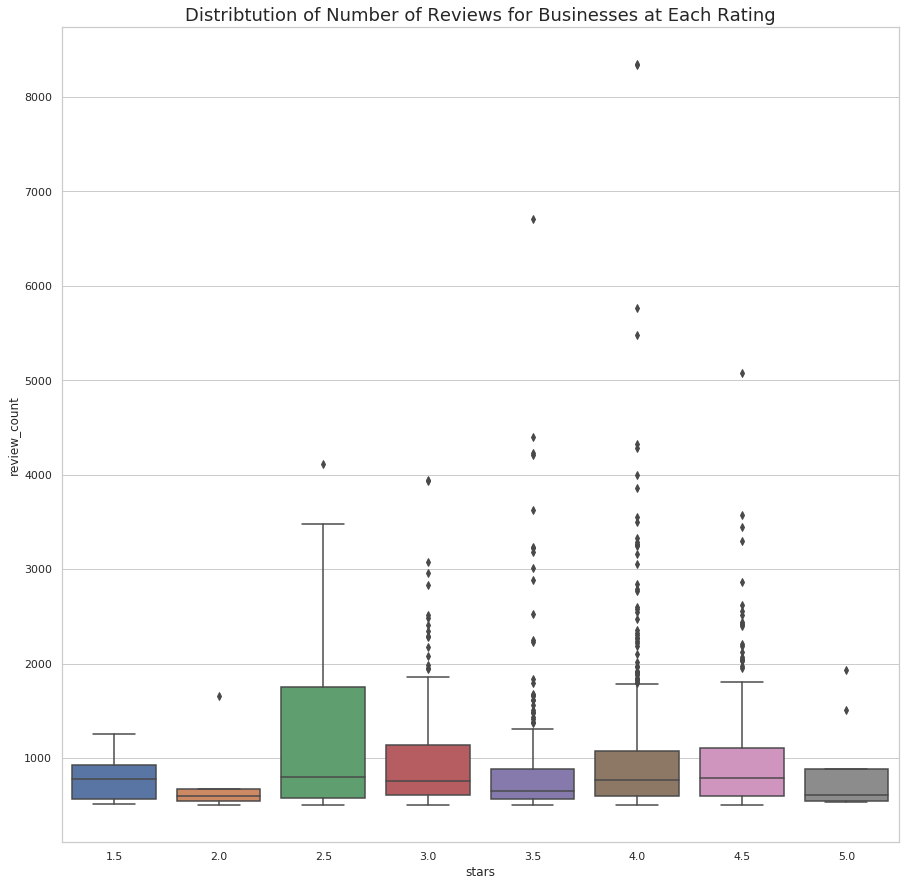

In [124]:
fig = plt.figure(figsize=(15,15))
sns.boxplot(x = 'stars', y = 'review_count', data = business).set_title('Distribtution of Number of Reviews for Businesses at Each Rating', fontsize = 18)

Text(0.5,1,'Distribtution of Number of Reviews for Businesses at Each Rating with Boxenplot')

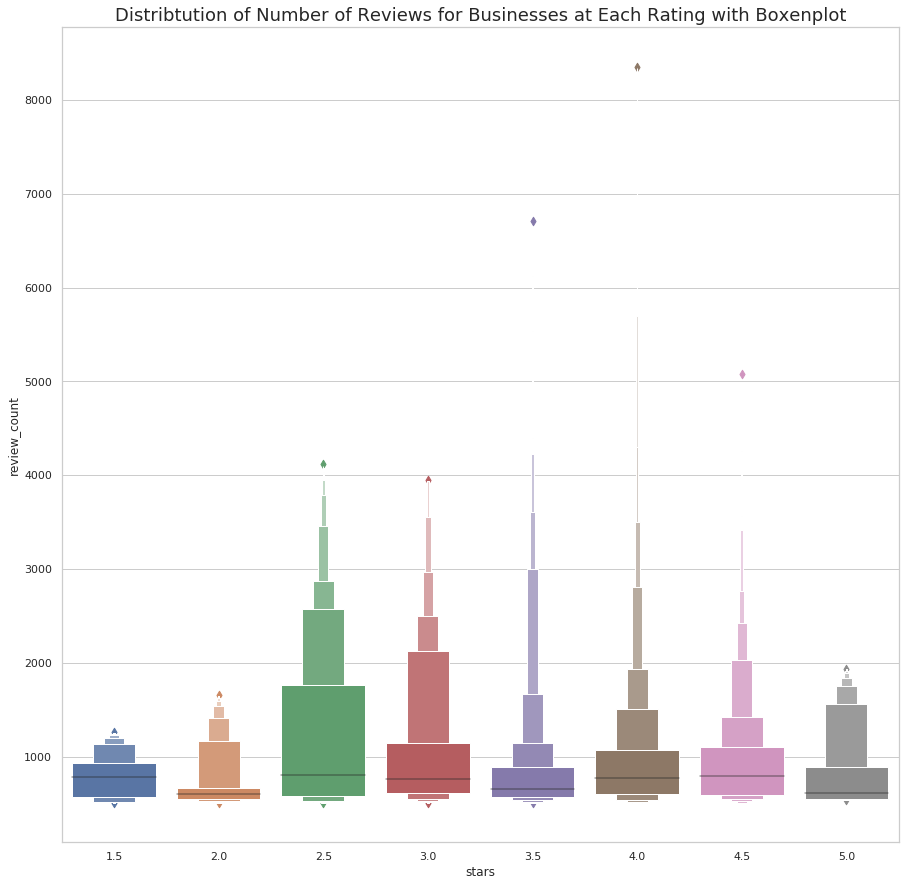

In [122]:
fig = plt.figure(figsize=(15,15))
sns.boxenplot(x = 'stars', y = 'review_count', data = business).set_title('Distribtution of Number of Reviews for Businesses at Each Rating with Boxenplot', fontsize = 18)


Taking a look at the locations of the businesses we see that most are in Las Vegas, Nevada and Phoenix, Arizona and Scottsdale, Arizona



In [267]:
business['state'].unique()

array(['NV', 'AZ', 'PA', 'WI', 'OH', 'ON', 'NC', 'QC', 'TX', 'FL', 'IL'],
      dtype=object)

Text(0.5,1,'Number of Businesses in Each State')

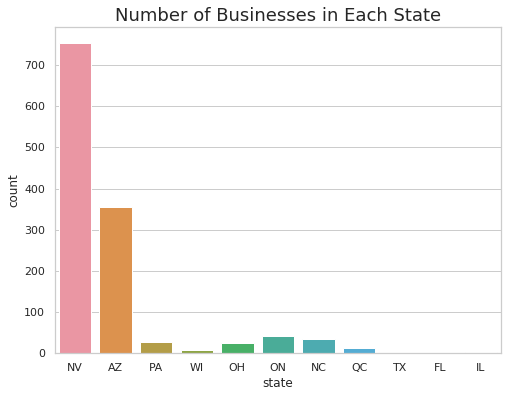

In [268]:
fig = plt.figure(figsize=(8,6))
sns.set(style = 'whitegrid')
sns.countplot(business['state']).set_title('Number of Businesses in Each State',fontsize = 18)

In [271]:
business[business['state'] == 'NV']['city'].unique()

array(['Henderson', 'Las Vegas', 'Spring Valley', 'North Las Vegas',
       'Boulder City', 'Summerlin'], dtype=object)

In [272]:
business[business['state'] == 'AZ']['city'].unique()

array(['Scottsdale', 'Phoenix', 'Glendale', 'Tempe', 'Chandler',
       'Gilbert', 'Litchfield Park', 'Goodyear', 'Mesa', 'Cave Creek',
       'Paradise Valley', 'Surprise', 'Avondale', 'Peoria'], dtype=object)

Text(0.5,1,'Number of Businesses in Each City in Nevada')

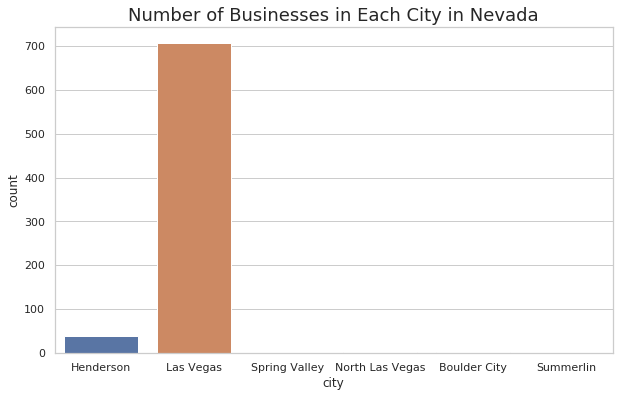

In [277]:
fig = plt.figure(figsize=(10,6))
sns.set(style = 'whitegrid')
sns.countplot(business[business['state'] == 'NV']['city']).set_title('Number of Businesses in Each City in Nevada',fontsize = 18)

Text(0.5,1,'Number of Businesses in Each City in Arizonaa')

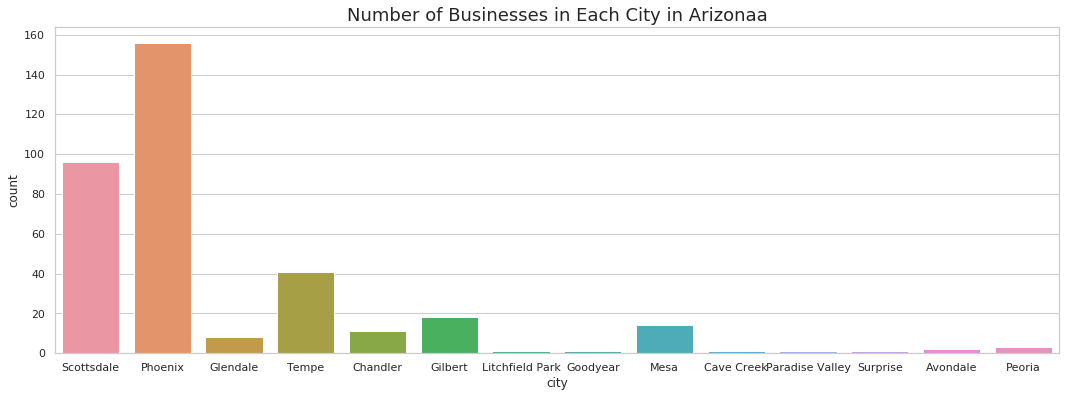

In [279]:
fig = plt.figure(figsize=(18,6))
sns.set(style = 'whitegrid')
sns.countplot(business[business['state'] == 'AZ']['city']).set_title('Number of Businesses in Each City in Arizonaa',fontsize = 18)

# Text Analysis

## Exploratory Analysis

Wordclouds for reviews at each rating {1,2,3,4,5} without text normalization

In the one and two star reviews, you can see words such "worst", "horrible", "mediocre", "overpriced", and "bad" as expected. Although, you see some positive words as well such as "great" or "good" which may suggest to use NGram models to get more context when modeling. In the higher star reviews we mostly see words such as "amazing" or "awesome" which is a good indicator of what types of words may be predictive of high reviews.

In [354]:
def show_wordcloud(data, title = None): #function to show word cloud copied from stackoverflow
    wordcloud = WordCloud(
        background_color='white',
        width = 200,
        height = 100,
        max_words=20,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

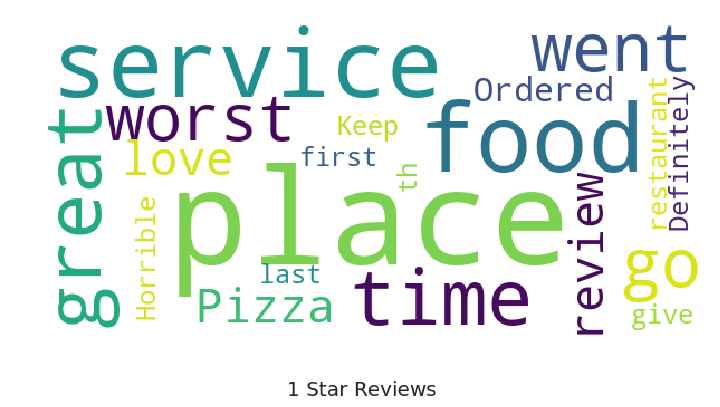

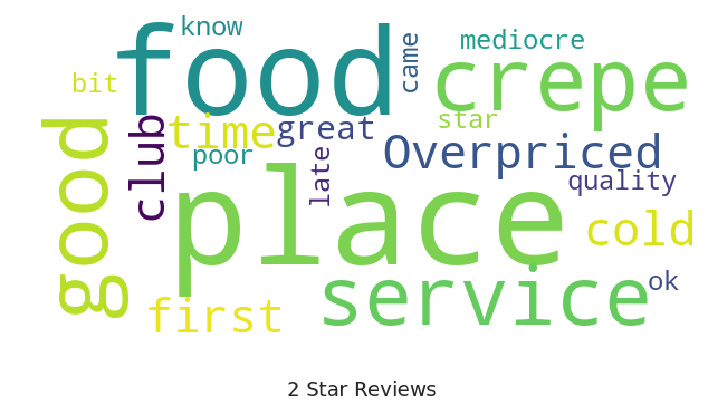

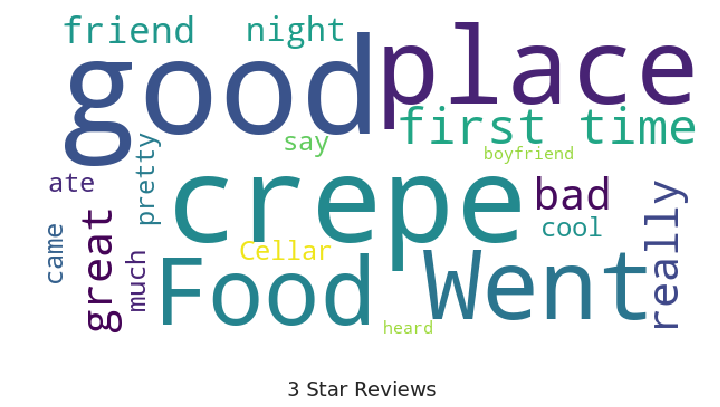

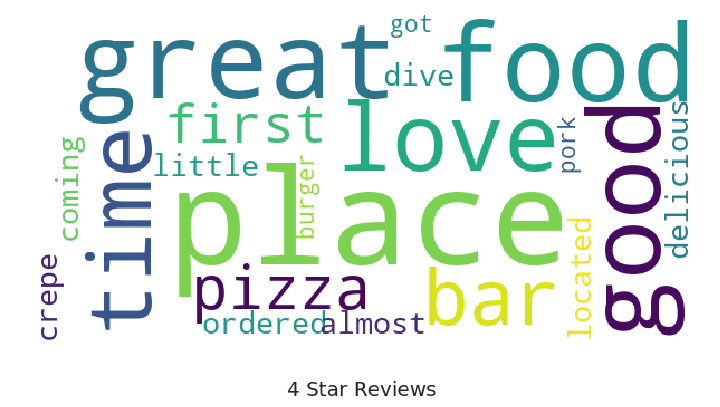

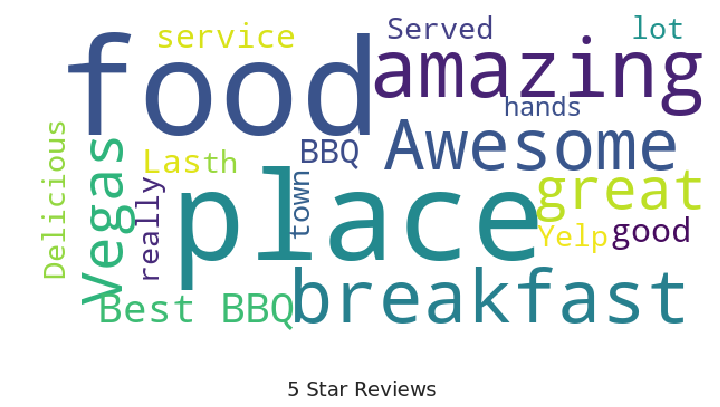

In [355]:
for s in [1,2,3,4,5]:
    show_wordcloud(reviews[reviews['stars'] == s]['text'], title = str(s) + " Star Reviews")

# Modeling

- TfidiVectorizer does text normalization e.g. strips special characters, lowercase strings, remove stopwords, and computes tfidf values all in one step, e.g. term frequency, doc frequency and idf values

- Multiclassclassification, stars (classes): 1,2,3,4,5

- Model Selection:
    -Begin with unigram tfidf values
    -Try NGram
    -Include other features: sentiment scores, funny, cool, useful
    -Use Cross-Validation for parameter selection and model tuning
    -Evaluate on validation set
    -Class weight = 'balanced' to address class imbalance (most reviewes are 5's)
    -Algorithms:
        1. Naive Bayes
            -Gaussian
            -Multinomial
        2. Logistic Regression
        3. Support Vector Machine

## Include sentiment analysis scores

In [5]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/aaron/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
sentScores = reviews['text'].map(lambda row: sid.polarity_scores(row)).apply(pd.Series)

In [7]:
sentScores.head()

,neg,neu,pos,compound
0,0.038,0.818,0.144,0.9391
1,0.000,0.897,0.103,0.7067
2,0.000,0.802,0.198,0.8966
3,0.016,0.745,0.239,0.9952
4,0.065,0.641,0.294,0.9125


In [8]:
sentScores.tail()

,neg,neu,pos,compound
63145,0.045,0.748,0.207,0.9602
63146,0.113,0.591,0.296,0.9586
63147,0.080,0.816,0.104,0.3138
63148,0.063,0.622,0.315,0.9639
63149,0.119,0.849,0.032,-0.6521


In [9]:
reviews = pd.concat([reviews, sentScores], axis = 1)

In [10]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,neg,neu,pos,compound
0,jScBTQtdAt-8RshaiBEHgw,0,2016-06-21 20:54:28,0,1jKn3mgSamCvmAPYRwRsew,3,First time here and i would like to say the pl...,1,WXA_4WVO1tpD0So3pZOQQQ,0.038,0.818,0.144,0.9391
1,jScBTQtdAt-8RshaiBEHgw,3,2016-07-02 18:37:12,1,rtGw_i8FcpwIRNS1OWmuHA,5,I hope that this place makes it because everyt...,3,bgn06l4XfW9P_-TgLPS3tw,0.000,0.897,0.103,0.7067
2,jScBTQtdAt-8RshaiBEHgw,1,2018-01-11 02:42:38,0,S0R9z62w4Rzc741reFNBmg,4,I had the miso pork belly burger and the thing...,1,hJnqE_-Ijr55MFkbc1YghQ,0.000,0.802,0.198,0.8966
3,jScBTQtdAt-8RshaiBEHgw,2,2017-10-20 01:14:01,0,Ot5kLJ3TDk0YXZ1FBaoESg,5,Delicious food with very friendly and accommod...,3,fMSmWCg5ge5pxVlbCgjtxQ,0.016,0.745,0.239,0.9952
4,jScBTQtdAt-8RshaiBEHgw,1,2018-03-07 22:42:02,1,-FVXDl7uUeIiHuk5Jql8aQ,5,This place is definitely worth the search. Loc...,1,Gn_06I6jbXgKtc64SEuIVw,0.065,0.641,0.294,0.9125


In [5]:
#tfidf_vect handles the text preprocessing steps and tf-idf steps, NOTE stemming and lemmatization were not used
tfidf_vec = TfidfVectorizer(max_df = 0.90, min_df = 20, stop_words = 'english', strip_accents = 'ascii', lowercase = True)
TFIDF_df = tfidf_vec.fit_transform(reviews['text'])
TFIDF_df = pd.DataFrame(TFIDF_df.toarray(), columns = tfidf_vec.get_feature_names())

In [5]:
TFIDF_df.head()

,00,000,00am,00pm,05,06,10,100,1000,101,...,zest,zinburger,zinc,zing,zip,zombie,zone,zoo,zucchini,zumanity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X_Train_tfidf, X_Test_tfidf, Y_Train_tfidf, Y_Test_tfidf = train_test_split(TFIDF_df, reviews['stars'], test_size = 0.2, random_state = 69)

In [21]:
fullTextFeats = pd.concat([TFIDF_df, reviews[['cool', 'funny', 'useful', 'neg', 'neu', 'pos', 'compound']]], axis = 1)

In [23]:
fullTextFeats.head()

,00,000,00am,00pm,05,06,10,100,1000,101,...,zoo,zucchini,zumanity,cool,funny,useful,neg,neu,pos,compound
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,1,0.038,0.818,0.144,0.9391
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3,1,3,0.000,0.897,0.103,0.7067
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,1,0.000,0.802,0.198,0.8966
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,0,3,0.016,0.745,0.239,0.9952
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1,1,0.065,0.641,0.294,0.9125


In [24]:
X_Train_feats, X_Test_feats, Y_Train_feats, Y_Test_feats = train_test_split(fullTextFeats, reviews['stars'], test_size = 0.2, random_state = 420)

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize = False, title = None, cmap = plt.cm.Blues):
    # CODE FROM SKLEARN DOCUMENTATION
    cm = metrics.confusion_matrix(y_true, y_pred)

    
    print('Confusion Matrix')
    print(cm)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots(figsize = (12,12))
    im = ax.imshow(cm, interpolation = 'nearest', cmap = cmap)
    ax.figure.colorbar(im, ax = ax)
    
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           xticklabels = classes, yticklabels = classes,
           title = title,
           ylabel = 'True label',
           xlabel = 'Predicted label')
    
     # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
def log_reg(X_Train, Y_Train, X_Test, Y_Test, scale = False, weight = False):
      
    if weight:
        logReg = LogisticRegression(class_weight='balanced')
    else:
        logReg = LogisticRegression()
        
    param_grid = [{'penalty': ['l2'], 'C': np.linspace(0.1,1,10)}]
    
    #NOT USEFUL FOR TFIDF
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_Train)
        X_Train = scaler.transform(X_Train)
        scaler.fit(X_Test)
        X_Test = scaler.transform(X_Test)

    
    
    clf = GridSearchCV(logReg, param_grid, cv = 5)#GRID SEARCH CV
    clf.fit(X_Train, Y_Train)
    
     
    predictions = clf.predict(X_Test)
    
    
    acc = [metrics.accuracy_score(Y_Test, predictions)]
    rec = [metrics.recall_score(Y_Test, predictions, labels = [1,2,3,4,5], average = 'macro')]
    prec = [metrics.precision_score(Y_Test, predictions, labels = [1,2,3,4,5], average = 'macro')]

    plot_confusion_matrix(Y_Test, predictions, classes = [1,2,3,4,5],normalize = True, title = 'Normalized Logistic Regression Confusion Matrix')
    

    print(clf.best_params_)
    data = {'Accuracy': acc, 'Recall': rec, 'Precision': prec}
    df = pd.DataFrame(data)
    
    return df

In [16]:
def gausNB(X_Train, Y_Train, X_Test, Y_Test, scale):
   
    nb = GaussianNB()
    param_grid = [{'var_smoothing': np.linspace(0.1,1,10)}]
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_Train)
        X_Train = scaler.transform(X_Train)
        scaler.fit(X_Test)
        X_Test = scaler.transform(X_Test)

    clf = GridSearchCV(nb, param_grid, cv = 5)
    clf.fit(X_Train, Y_Train)
    
    predictions = clf.predict(X_Test)
    
    
    acc = [metrics.accuracy_score(Y_Test, predictions)]
    rec = [metrics.recall_score(Y_Test, predictions, labels = [1,2,3,4,5], average = 'macro')]
    prec = [metrics.precision_score(Y_Test, predictions, labels = [1,2,3,4,5], average = 'macro')]
    
    
    plot_confusion_matrix(Y_Test, predictions, classes = [1,2,3,4,5],normalize = True, title = 'Normalized Gaussian Naive Bayes Confusion Matrix')
   

    print(clf.best_params_)
    data = {'Accuracy': acc, 'Recall': rec, 'Precision': prec}
    df = pd.DataFrame(data)
    
    return df

In [17]:
def multNB(X_Train, Y_Train, X_Test, Y_Test, scale, weight):
    
    if weight:
        nb = ComplementNB()
    else:
        nb = MultinomialNB()
    param_grid = [{'alpha': np.linspace(0.1,1,10)}]
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_Train)
        X_Train = scaler.transform(X_Train)
        scaler.fit(X_Test)
        X_Test = scaler.transform(X_Test)

    clf = GridSearchCV(nb, param_grid, cv = 5)
    clf.fit(X_Train, Y_Train)
    
    predictions = clf.predict(X_Test)
    
    
    acc = [metrics.accuracy_score(Y_Test, predictions)]
    rec = [metrics.recall_score(Y_Test, predictions, labels = [1,2,3,4,5], average = 'macro')]
    prec = [metrics.precision_score(Y_Test, predictions, labels = [1,2,3,4,5], average = 'macro')]
    
    if weight:
        plot_confusion_matrix(Y_Test, predictions, classes = [1,2,3,4,5],normalize = True, title = 'Normalized Complement Naive Bayes Confusion Matrix')
    else:     
        plot_confusion_matrix(Y_Test, predictions, classes = [1,2,3,4,5],normalize = True, title = 'Normalized Multinomial Naive Bayes Confusion Matrix')
   

    print(clf.best_params_)
    data = {'Accuracy': acc, 'Recall': rec, 'Precision': prec}
    df = pd.DataFrame(data)
    
    return df

Confusion Matrix
[[ 857  128   76   73   84]
 [ 238  217  243  157  128]
 [ 104  133  480  568  288]
 [  32   17  156 1399 1670]
 [  25    3   32  650 4872]]
{'C': 1.0, 'penalty': 'l2'}


,Accuracy,Recall,Precision
0,0.619557,0.505925,0.557527


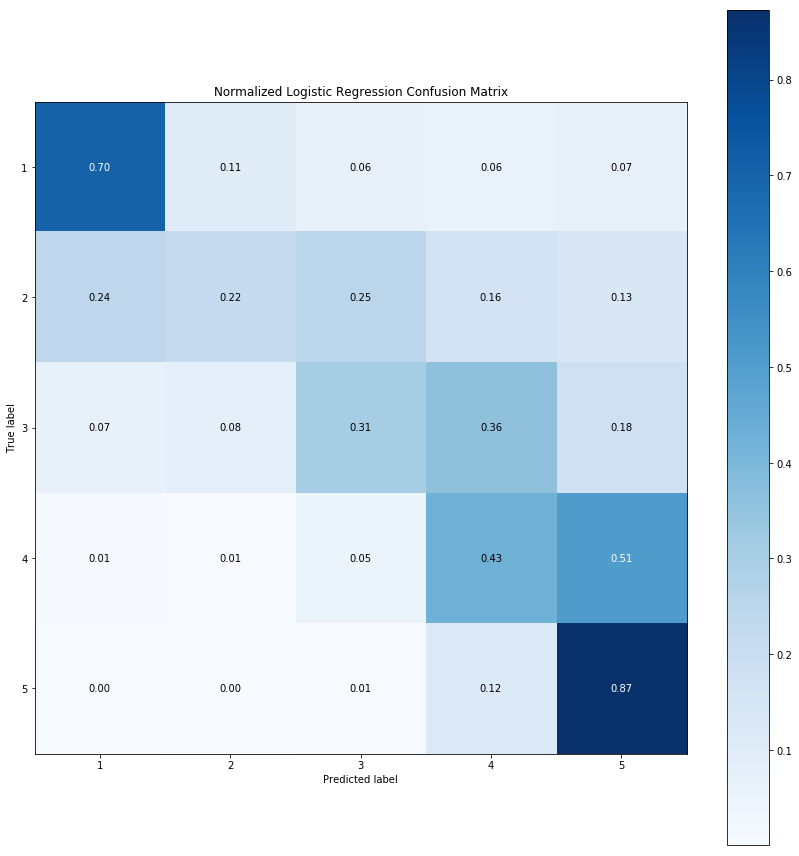

In [18]:
log_reg(X_Train_tfidf, Y_Train_tfidf, X_Test_tfidf, Y_Test_tfidf, scale = False, weight = False)

Confusion Matrix
[[ 898  209   61   13   37]
 [ 253  374  254   52   50]
 [ 138  265  642  367  161]
 [  80  103  403 1436 1252]
 [  84   55  135  833 4475]]
{'C': 0.4, 'penalty': 'l2'}


,Accuracy,Recall,Precision
0,0.619557,0.553234,0.539968


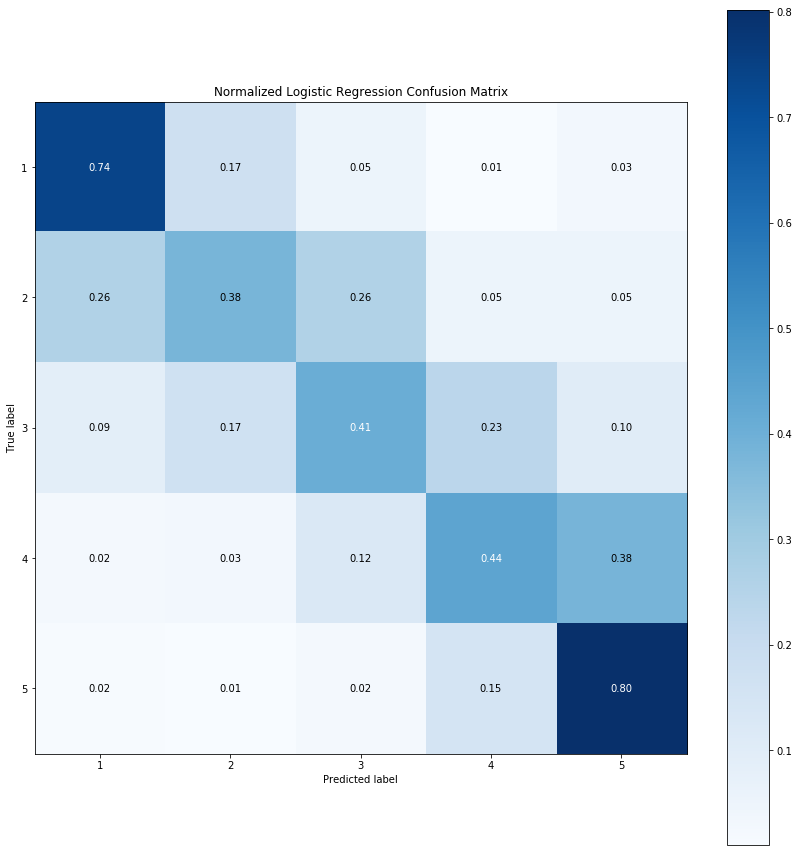

In [19]:
log_reg(X_Train_tfidf, Y_Train_tfidf, X_Test_tfidf, Y_Test_tfidf, scale = False, weight = True)

Confusion Matrix
[[ 891  159   50   19   99]
 [ 329  252  180   64  158]
 [ 245  194  416  303  415]
 [ 206   80  240  731 2017]
 [ 195   31   71  369 4916]]
{'var_smoothing': 0.9}


,Accuracy,Recall,Precision
0,0.570546,0.471262,0.480496


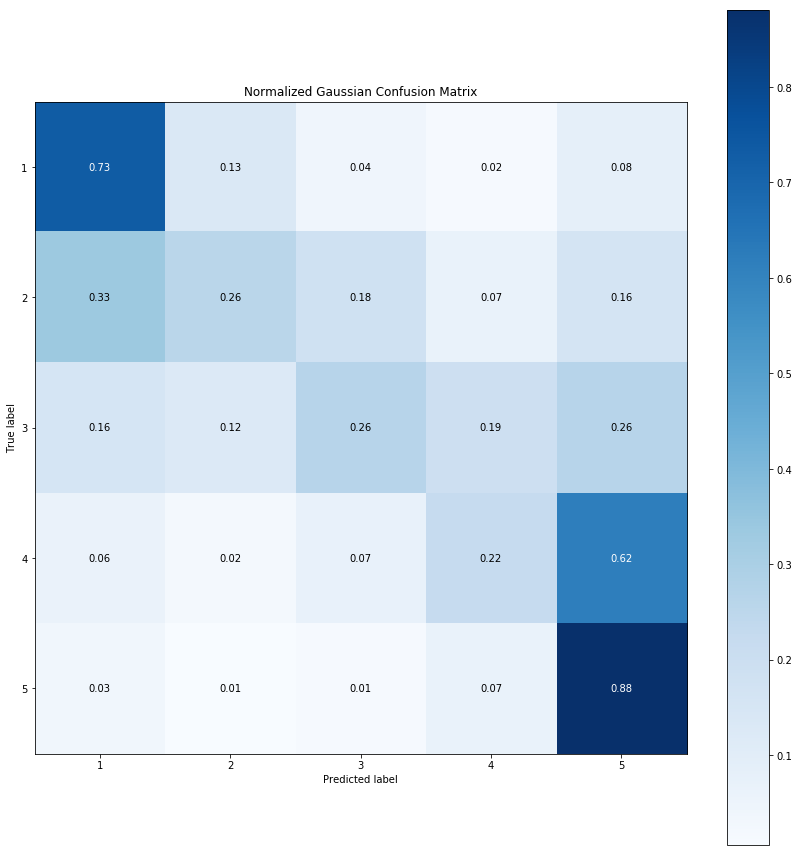

In [20]:
gausNB(X_Train_tfidf, Y_Train_tfidf, X_Test_tfidf, Y_Test_tfidf, scale = False)

Confusion Matrix
[[ 765  144   65   81  163]
 [ 239  133  171  244  196]
 [ 146   77  205  639  506]
 [  79   13   78 1002 2102]
 [  74    5   18  452 5033]]
{'alpha': 0.1}


,Accuracy,Recall,Precision
0,0.565162,0.42028,0.47398


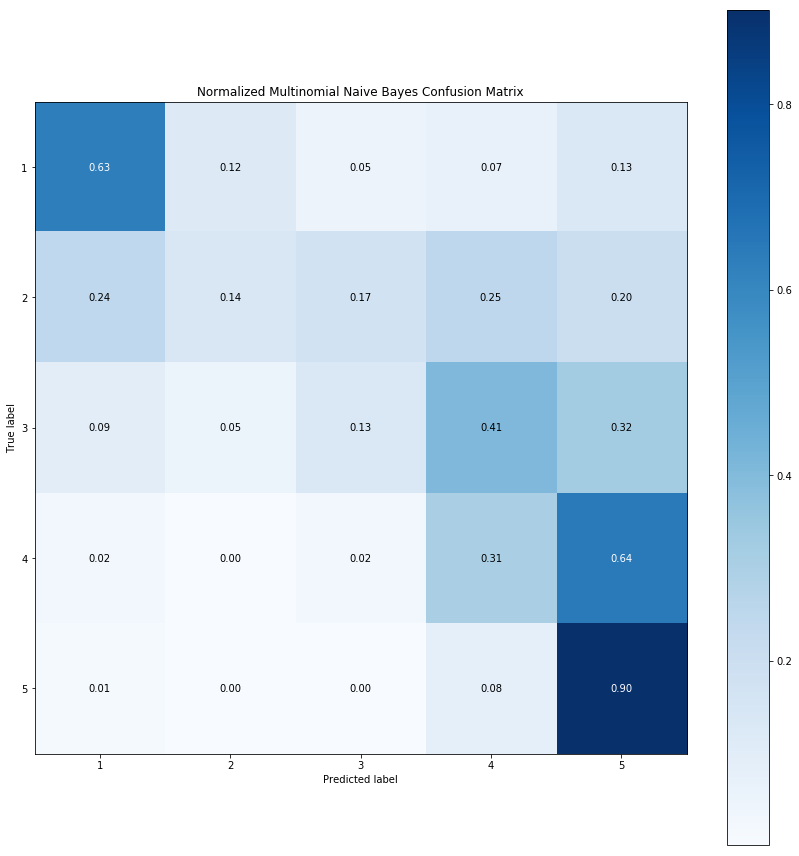

In [25]:
multNB(X_Train_tfidf, Y_Train_tfidf, X_Test_tfidf, Y_Test_tfidf, scale = False, weight = False)

Confusion Matrix
[[1062   68   41   19   28]
 [ 503  173  161   87   59]
 [ 405  146  351  432  239]
 [ 399   64  209  942 1660]
 [ 359   35   74  461 4653]]
{'alpha': 0.8}


,Accuracy,Recall,Precision
0,0.568567,0.478469,0.470259


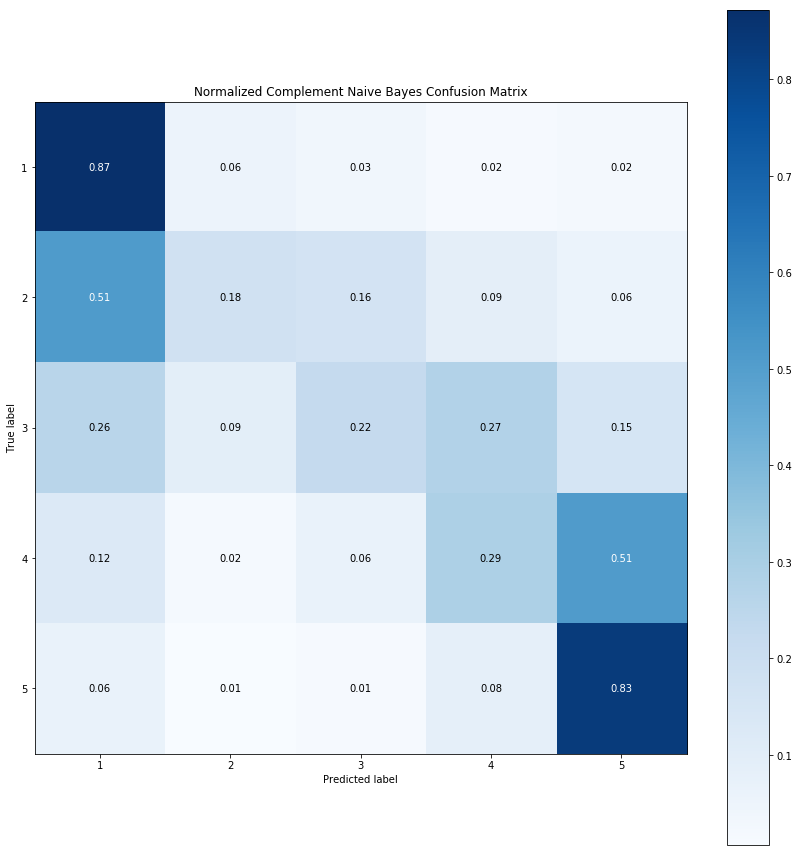

In [26]:
multNB(X_Train_tfidf, Y_Train_tfidf, X_Test_tfidf, Y_Test_tfidf, scale = False, weight = True)

## Full Features

Confusion Matrix
[[ 887  122   72   40   71]
 [ 291  260  256  116  106]
 [ 118  120  455  617  235]
 [  35   20  155 1429 1661]
 [  31    7   38  674 4814]]
{'C': 1.0, 'penalty': 'l2'}


,Accuracy,Recall,Precision
0,0.62114,0.517907,0.56096


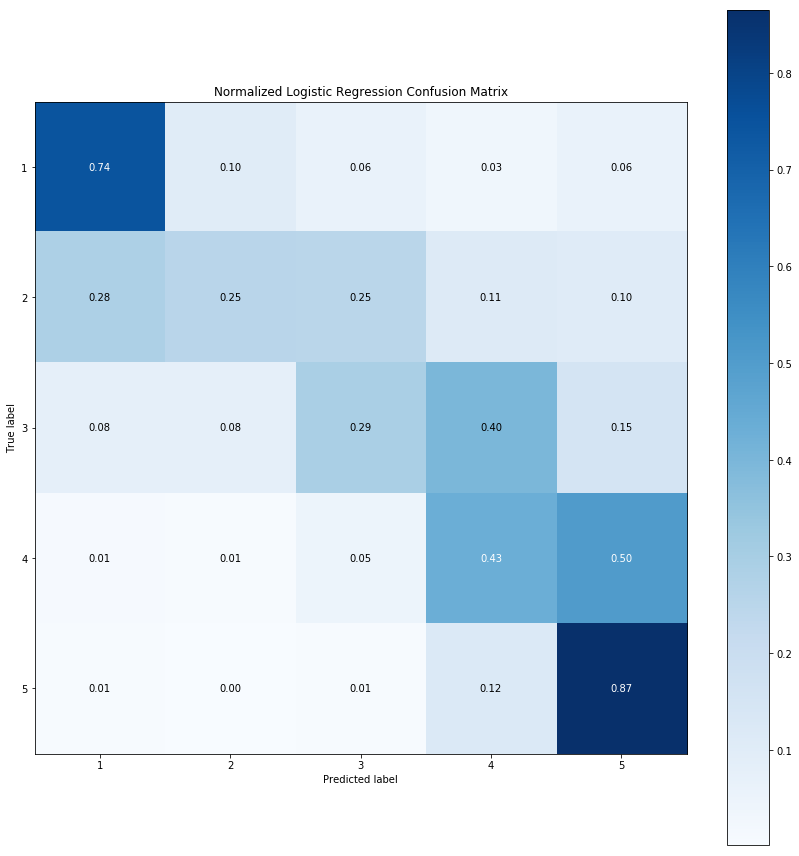

In [25]:
log_reg(X_Train_feats, Y_Train_feats, X_Test_feats, Y_Test_feats, scale = False, weight = False)

Confusion Matrix
[[ 889  196   64   15   28]
 [ 309  391  244   45   40]
 [ 152  254  637  373  129]
 [  75   74  388 1443 1320]
 [  94   57  131  873 4409]]
{'C': 0.4, 'penalty': 'l2'}


,Accuracy,Recall,Precision
0,0.615123,0.553554,0.538311


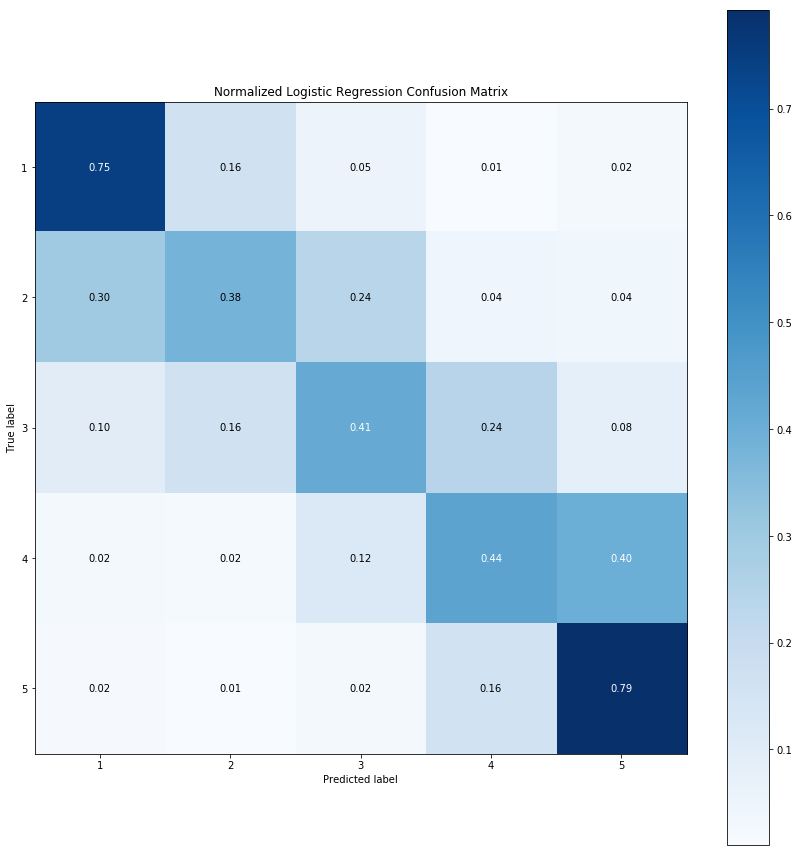

In [27]:
log_reg(X_Train_feats, Y_Train_feats, X_Test_feats, Y_Test_feats, scale = False, weight = True)

### The best model is Logistic Regression with L2 penalty and C = 0.4 using only TF-IDF features and a class weight balancer for our unbalanced classes. We can see our model is very good at predicting 1 and 5 star reviews but less effective at predicting 2, 3, and 4 star reviews. However, if we look at the confusion matrix we see that the model usually predicts very close, e.g. if the true value is 2 it is sometimes predicted as a 1 or a 3 but rarely a 4 or 5, this suggests our model is still good at predicting close to the actual star rating. Thus a good model will have strong values in the confusion matrix along the diagonal or close to the diagonal.

In [9]:
lr = LogisticRegression(penalty= 'l2', C = 0.4, class_weight = 'balanced')

In [10]:
lr.fit(X_Train_tfidf, Y_Train_tfidf)

/home/aaron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aaron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.4, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [11]:
preds = lr.predict(X_Test_tfidf)

In [12]:
X_Test_tfidf.head()

,00,000,00am,00pm,05,06,10,100,1000,101,...,zest,zinburger,zinc,zing,zip,zombie,zone,zoo,zucchini,zumanity
29542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
Y_Test_tfidf.head()

29542    5
39605    1
11706    1
48722    4
12863    5
Name: stars, dtype: int64

In [14]:
preds

array([5, 1, 5, ..., 5, 5, 4])

In [15]:
preds = pd.Series(preds, index= Y_Test_tfidf.index)
preds.head()

29542    5
39605    1
11706    5
48722    5
12863    5
dtype: int64

In [16]:
testData = reviews[reviews.index.isin(X_Test_tfidf.index)]

In [17]:
testData.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
8,jScBTQtdAt-8RshaiBEHgw,0,2017-12-30 00:22:36,0,mQOmM--z_KS26lHQLss7UA,2,"After reading all the high ratings, I felt con...",2,RVAwxduvdp5dv5lSsEKEPg
12,jScBTQtdAt-8RshaiBEHgw,4,2016-05-20 18:07:37,0,aL4EljUQK0WgE-ESmQdW9A,5,"Had the 3-item Custom Burger with avocado, che...",4,G6s6-p-UMJyi73wuj2CJEw
22,jScBTQtdAt-8RshaiBEHgw,2,2016-11-21 20:29:25,0,-rmiCQ6Mol5TA2V2pYz-cw,5,I found this place here on Yelp and saw really...,2,n0r_0HkCFaC175vXtIVcaQ
27,jScBTQtdAt-8RshaiBEHgw,0,2017-05-30 01:20:30,0,o-145tX285rctLpeDswQrw,2,Overpriced and bland. Found this place on yel...,1,UcmjgcFV2wTwoNAQTSfffw
29,jScBTQtdAt-8RshaiBEHgw,0,2018-09-02 00:51:38,0,RgfhAGH9okRa79xNU27MhA,5,This place was amazing. My burger was enormous...,0,8pgzQ1B1NT9_rEK4QLNwZA


In [18]:
preds.sort_index().head()

8     2
12    5
22    4
27    2
29    5
dtype: int64

In [19]:
testData['preds'] = preds.sort_index()

/home/aaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
testData.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,preds
8,jScBTQtdAt-8RshaiBEHgw,0,2017-12-30 00:22:36,0,mQOmM--z_KS26lHQLss7UA,2,"After reading all the high ratings, I felt con...",2,RVAwxduvdp5dv5lSsEKEPg,2
12,jScBTQtdAt-8RshaiBEHgw,4,2016-05-20 18:07:37,0,aL4EljUQK0WgE-ESmQdW9A,5,"Had the 3-item Custom Burger with avocado, che...",4,G6s6-p-UMJyi73wuj2CJEw,5
22,jScBTQtdAt-8RshaiBEHgw,2,2016-11-21 20:29:25,0,-rmiCQ6Mol5TA2V2pYz-cw,5,I found this place here on Yelp and saw really...,2,n0r_0HkCFaC175vXtIVcaQ,4
27,jScBTQtdAt-8RshaiBEHgw,0,2017-05-30 01:20:30,0,o-145tX285rctLpeDswQrw,2,Overpriced and bland. Found this place on yel...,1,UcmjgcFV2wTwoNAQTSfffw,2
29,jScBTQtdAt-8RshaiBEHgw,0,2018-09-02 00:51:38,0,RgfhAGH9okRa79xNU27MhA,5,This place was amazing. My burger was enormous...,0,8pgzQ1B1NT9_rEK4QLNwZA,5


In [21]:
testPredsMean = testData.groupby('business_id', as_index = False)['preds'].mean()

In [22]:
testPredsMean.head()

,business_id,preds
0,--9e1ONYQuAa-CB_Rrw7Tw,4.500000
1,-050d_XIor1NpCuWkbIVaQ,4.090909
2,-3zffZUHoY8bQjGfPSoBKQ,4.857143
3,-6h3K1hj0d4DRcZNUtHDuw,3.222222
4,-6tvduBzjLI1ISfs3F_qTg,4.125000


In [23]:
b = business[['business_id', 'stars']]
b.head()

,business_id,stars
0,jScBTQtdAt-8RshaiBEHgw,4.5
1,nsNONDHbV7Vudqh21uicqw,3.5
2,6fPQJq4f_yiq1NHn0fd11Q,3.5
3,dUffgo9Lh_Vk9TLuFR5ywg,3.5
4,_pBXtjN43eqMV0XZTz7nmw,3.5


In [24]:
predsBusiness = pd.merge(testPredsMean, b, on= 'business_id', how= 'left')

In [25]:
predsBusiness

,business_id,preds,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,4.500000,4.0
1,-050d_XIor1NpCuWkbIVaQ,4.090909,4.0
2,-3zffZUHoY8bQjGfPSoBKQ,4.857143,4.0
3,-6h3K1hj0d4DRcZNUtHDuw,3.222222,3.5
4,-6tvduBzjLI1ISfs3F_qTg,4.125000,4.0
5,-7H-oXvCxJzuT42ky6Db0g,3.454545,3.5
6,-95mbLJsa0CxXhpaNL4LvA,3.600000,3.5
7,-9dmhyBvepc08KPEHlEM0w,3.500000,4.0
8,-Bdw-5H5C4AYSMGnAvmnzw,4.300000,4.5
9,-Dnh48f029YNugtMKkkI-Q,3.875000,4.0


In [27]:
def roundStars(star):
    if star >= 1.0 and star < 1.25:
        rstar = 1
    elif star >= 1.25 and star < 1.74:
        rstar = 1.5
    elif star >= 1.75 and star < 2.24:
        rstar = 2
    elif star >= 2.25 and star < 2.74:
        rstar = 2.5
    elif star >= 2.75 and star < 3.24:
        rstar = 3
    elif star >= 3.25 and star < 3.74:
        rstar = 3.5
    elif star >= 3.75 and star < 4.24:
        rstar = 4
    elif star >= 4.25 and star < 4.74:
        rstar = 4.5
    elif star >= 4.75:
        rstar = 5
    return rstar

In [30]:
predsBusiness['round Preds'] = predsBusiness['preds'].map(roundStars)

In [31]:
predsBusiness.head()

,business_id,preds,stars,round Preds
0,--9e1ONYQuAa-CB_Rrw7Tw,4.500000,4.0,4.5
1,-050d_XIor1NpCuWkbIVaQ,4.090909,4.0,4.0
2,-3zffZUHoY8bQjGfPSoBKQ,4.857143,4.0,5.0
3,-6h3K1hj0d4DRcZNUtHDuw,3.222222,3.5,3.0
4,-6tvduBzjLI1ISfs3F_qTg,4.125000,4.0,4.0


Confusion Matrix
[[  0   0   0   0   0   0   0   0   0]
 [  6   1   1   1   0   0   0   0   0]
 [  0   2   3   0   0   0   0   0   0]
 [  1   5   7   8  10   3   0   0   0]
 [  0   1   6  24  30  18  14   0   0]
 [  0   0   3  16  47 100  76  16   2]
 [  0   0   1   3  30 124 220 172  22]
 [  0   0   0   0   1  12  77 137  55]
 [  0   0   0   0   0   0   0   3   5]]


/home/aaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


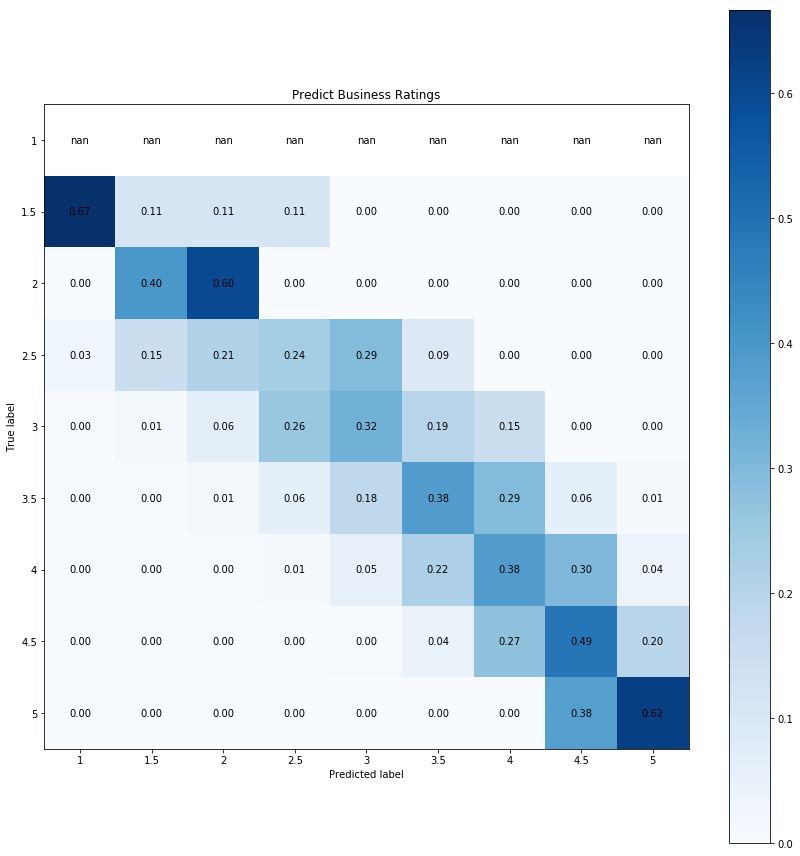

In [37]:
plot_confusion_matrix(predsBusiness['stars'].astype(str), predsBusiness['round Preds'].astype(str), classes = list(map(str, [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])), normalize = True, title = 'Predict Business Ratings')

### By taking the averages of the predicted stars of the reviews we can predict the star rating of the business. As we can see our model can predict the business rating reasonably well since the confusion matrix has strong values along the diagonal. NOTE: there are no 1 star businesses, the minimum is 1.5 so we can discard the 1 class

In [41]:
tfidf_vec = TfidfVectorizer(max_df = 0.95, min_df = 10, stop_words = 'english')
tfidf = tfidf_vec.fit_transform(reviews['text'])
tfidf_feat_names = tfidf_vec.get_feature_names()

tf_vec = CountVectorizer(max_df = 0.95, min_df = 10, stop_words = "english")
tf = tf_vec.fit_transform(reviews['text'])
tf_feat_names = tf_vec.get_feature_names()

In [44]:
nmf = NMF(n_components= 20).fit(tfidf)
lda = LatentDirichletAllocation(n_topics= 20).fit(tf)

/home/aaron/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [45]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topics: ", topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words  - 1:-1]]))

print('NMF')
display_topics(nmf, tfidf_feat_names, 20)
print('\n\nLDA')
display_topics(lda, tf_feat_names, 20)

NMF
Topics:  0
just time like got didn order came table said don minutes asked did took people server went told know drink
Topics:  1
great atmosphere service awesome beer selection drinks time experience fun spot music loved fantastic bar location night server definitely job
Topics:  2
room hotel stay rooms pool nice strip casino stayed clean desk floor view check night bed bathroom resort hotels staying
Topics:  3
place recommend try awesome eat like definitely cool looking fun nice friends highly just want really don people area small
Topics:  4
pizza crust slice cheese pepperoni pizzas salad garlic sauce chicago slices sausage italian style toppings deep oven wings pasta ny
Topics:  5
good really pretty nice beer little selection price overall prices bit atmosphere like decent liked lot got pricey enjoyed cool
Topics:  6
sushi rolls roll fresh fish ayce eat quality tuna sashimi rice nigiri salmon japanese favorite places price tempura chefs service
Topics:  7
delicious salad cheese